Import Necessary Libraries

Training set size: 35000
Validation set size: 7500
Test set size: 7500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 118s 425ms/step - accuracy: 0.0109 - loss: 6.4863 - val_accuracy: 0.0553 - val_loss: 5.5841
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 145s 435ms/step - accuracy: 0.0588 - loss: 5.4231 - val_accuracy: 0.2489 - val_loss: 4.1629
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 427ms/step - accuracy: 0.3336 - loss: 3.5387 - val_accuracy: 0.6875 - val_loss: 1.4849
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 119s 436ms/step - accuracy: 0.6755 - loss: 1.4514 - val_accuracy: 0.8445 - val_loss: 0.7662
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 428ms/step - accuracy: 0.8196 - loss: 0.7643 - val_accuracy: 0.9241 - val_loss: 0.4139
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 421ms/step - accuracy: 0.9089 - loss: 0.3979 - val_accuracy: 0.9539 - val_loss: 0.2693
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 424ms/step - accuracy: 0.9496 - loss: 0.2192 - val_accuracy: 0.9680 - val_loss: 0.1929
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 424ms/step - accuracy: 0.9664 -

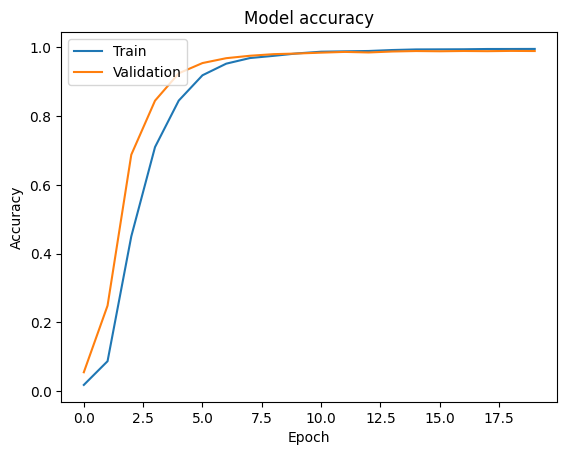

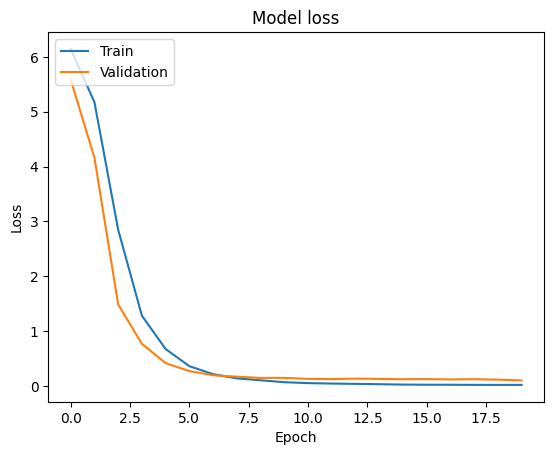

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


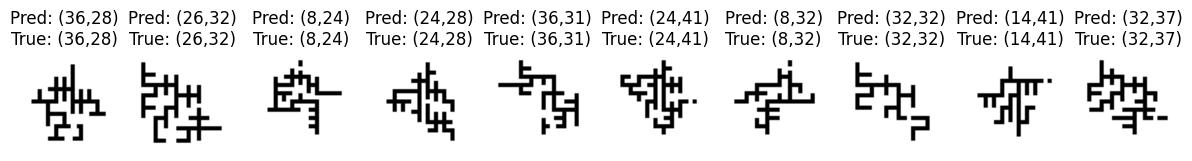

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_data(file_paths, num_samples_per_file=10000): # Reduced number of samples to load
    images = []
    centers = []

    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            for i in range(num_samples_per_file):
                img_key = f'img_{i}'
                center_key = f'center_{i}'

                # Check if the keys exist before accessing them
                if img_key in f and center_key in f:
                    img = np.array(f[img_key])
                    center = np.array(f[center_key])

                    images.append(img)
                    centers.append(center)
                else:
                    print(f"Warning: Key {img_key} or {center_key} not found in {file_path}")

    images = np.array(images)
    centers = np.array(centers)

    return images, centers

# List of HDF5 files
file_paths = [
    '/content/opens1.h5',
    '/content/opens2.h5',
    '/content/opens3.h5',
    '/content/opens4.h5',
    '/content/opens5.h5'
]

# Load the data
images, centers = load_data(file_paths)

# Normalize the images
images = images / 255.0

# Reshape images for model input
images = images.reshape(-1, 48, 48, 1)

# Convert centers to categorical labels
output_shape = 48 * 48  # 2304 classes
centers_categorical = centers[:, 0] * 48 + centers[:, 1]
centers_categorical = tf.keras.utils.to_categorical(centers_categorical, num_classes=output_shape)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, centers_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Build the CNN model
def build_model(input_shape, output_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flattening
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(output_shape, activation='softmax'))

    return model

input_shape = (48, 48, 1)
output_shape = 48 * 48  # 2304 classes for the 48x48 grid

model = build_model(input_shape, output_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Visualize training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Visualize some test results
def plot_test_results(model, X_test, y_test, num_samples=10):
    predictions = model.predict(X_test[:num_samples])
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[:num_samples], axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_test[i].reshape(48, 48), cmap='gray')
        plt.title(f"Pred: ({predictions[i] // 48},{predictions[i] % 48})\nTrue: ({true_labels[i] // 48},{true_labels[i] % 48})")
        plt.axis('off')
    plt.show()

plot_test_results(model, X_test, y_test)

# Save the model
model.save('vlsi_defect_detection_model.h5')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('vlsi_defect_detection_model.h5')

# Function to preprocess an image
def preprocess_image(img):
    img = img / 255.0  # Normalize
    img = img.reshape(1, 48, 48, 1)  # Reshape to match model input
    return img

# Function to predict defect location for an image
def predict_defect_location(model, img):
    processed_img = preprocess_image(img)
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction)
    predicted_x = predicted_class // 48
    predicted_y = predicted_class % 48
    return predicted_x, predicted_y

# Select a different image from the test set
index = 10  # Change this index to select a different image
custom_image = X_test[index].reshape(48, 48)  # The selected test image
actual_center = y_test[index]  # The actual defect location (x, y)

# Predict the defect location
predicted_x, predicted_y = predict_defect_location(model, custom_image)

# Print the results
print(f"Predicted defect location: ({predicted_x}, {predicted_y})")
print(f"Actual defect location: {tuple(actual_center)}")

# Check if the prediction is correct
is_correct = (predicted_x, predicted_y) == tuple(actual_center)
print(f"Prediction correct: {is_correct}")

# Visualize the selected image with predicted and actual defect location
plt.imshow(custom_image, cmap='gray')
plt.title(f"Predicted: ({predicted_x},{predicted_y}), Actual: {tuple(actual_center)}")
plt.plot(predicted_y, predicted_x, 'or', label="Predicted")  # 'or' for red marker (predicted)
plt.plot(actual_center[1], actual_center[0], 'og', label="Actual")  # 'og' for green marker (actual)
plt.legend()
plt.grid()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted defect location: (43, 19)
Actual defect location: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

ValueError: Image size of 85205x435 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [ ]:
def plot_test_results(model, X_test, y_test, num_samples=10):
    predictions = model.predict(X_test[:num_samples])
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[:num_samples], axis=1)

    plt.figure(figsize=(15, 15)) # Create a new figure for each call
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_test[i].reshape(48, 48), cmap='gray')

        # Ensure coordinates are within image bounds
        pred_x = predictions[i] // 48
        pred_y = predictions[i] % 48
        true_x = true_labels[i] // 48
        true_y = true_labels[i] % 48

        plt.title(f"Pred: ({pred_x},{pred_y})\nTrue: ({true_x},{true_y})")
        plt.axis('off')

        # Plot markers within image bounds
        plt.plot(pred_y, pred_x, 'or', label="Predicted")
        plt.plot(true_y, true_x, 'og', label="Actual")
        plt.xlim(0, 47) # Set x-axis limits to image width
        plt.ylim(47, 0) # Set y-axis limits to image height (inverted for image display)

    plt.legend()
    plt.grid()
    plt.show()